Nama : Faris Adnan Lugas

Peserta : FGA Digitalent

Program : Machine Learning

Project : Deployment Klasifikasi Gambar dengan format TFlite

In [ ]:
# Import Directory yang dibutuhkan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Import dataset yang akan digunakan
import os
import zipfile
local_zip = '/content/sportsimage.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Menginstal split folder
!pip install split_folders

In [ ]:
# Melakukan split folder
import splitfolders
base_dir = '/content/sportsimage'
splitfolders.ratio('/content/sportsimage/valid', '/content/sportsimage/data', seed=1337, ratio=(.8, .2))
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 365 files [00:00, 4198.62 files/s]


In [ ]:
os.listdir('/content/sportsimage')

['data', 'test', 'train', 'valid']

In [ ]:
# Melihat banyak file pada direktori
print('total train file :', len(os.listdir('/content/sportsimage/train')))
print('total val file :', len(os.listdir('/content/sportsimage/valid')))
print('total test file :', len(os.listdir('/content/sportsimage/test')))

total train file : 73
total val file : 73
total test file : 73


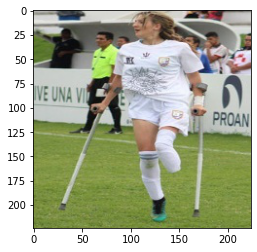

In [ ]:
# Melihat contah gambar dari dataset
from keras_preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img = image.load_img('/content/sportsimage/train/ampute football/001.jpg')
imgplot = plt.imshow(img)

In [ ]:
# Mengaplikasikan Augmentasi gambar pada dataset 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'wrap',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150,150),
    #class_mode='sparse',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150,150),
    #class_mode='sparse',
    subset='validation'
)

Found 9209 images belonging to 4 classes.
Found 2302 images belonging to 4 classes.


In [ ]:
# Membuat arsitektur dari model
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),

        tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.98):
      print("\nAccuracy dari model < 90% skala data")
      self.model.stop_training = True
callbacks = myCallback()
# Melakukan optimezier untuk menentukan optimezer dan loss pada model
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Menjalankan fungsi fit untuk melatih model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[callbacks],
                    verbose=2)

Epoch 1/20
288/288 - 463s - loss: 0.4607 - accuracy: 0.9016 - val_loss: 0.4395 - val_accuracy: 0.9049
Epoch 2/20
288/288 - 458s - loss: 0.4267 - accuracy: 0.9049 - val_loss: 0.4222 - val_accuracy: 0.9049
Epoch 3/20
288/288 - 459s - loss: 0.4278 - accuracy: 0.9049 - val_loss: 0.4335 - val_accuracy: 0.9049
Epoch 4/20
288/288 - 460s - loss: 0.4245 - accuracy: 0.9049 - val_loss: 0.4380 - val_accuracy: 0.9049
Epoch 5/20
288/288 - 460s - loss: 0.4243 - accuracy: 0.9049 - val_loss: 0.4211 - val_accuracy: 0.9049
Epoch 6/20
288/288 - 461s - loss: 0.4238 - accuracy: 0.9049 - val_loss: 0.4238 - val_accuracy: 0.9049
Epoch 7/20
288/288 - 459s - loss: 0.4276 - accuracy: 0.9049 - val_loss: 0.4203 - val_accuracy: 0.9049
Epoch 8/20
288/288 - 456s - loss: 0.4231 - accuracy: 0.9049 - val_loss: 0.4195 - val_accuracy: 0.9049
Epoch 9/20
288/288 - 456s - loss: 0.4242 - accuracy: 0.9049 - val_loss: 0.4391 - val_accuracy: 0.9049
Epoch 10/20
288/288 - 459s - loss: 0.4242 - accuracy: 0.9049 - val_loss: 0.4221 - 

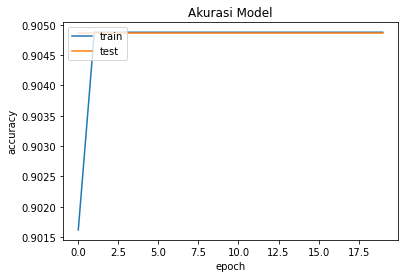

In [ ]:
# Melihat plot akurasi pada model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

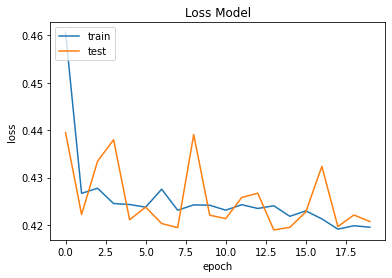

In [ ]:
# Melihat plot loss pada model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Model TensorFlow yang sudah di training di-convert menjadi tflite menggunakan TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9hg0nrjb/assets


INFO:tensorflow:Assets written to: /tmp/tmp9hg0nrjb/assets
